## **Making Forecasts Useful (Hydrological Categorization)**

#UKCEH West Africa Hydrological Forecasting Training Workshop 2026

Katie Facer-Childs, Ezra Kitson, Eugene Magee, Adriana Calderon, Lucy Barker
(c) UKCEH 2026


This code converts ESP forecasts into graphs and charts that facilitate decision making in the water sector. Its not the tidiest code (Sorry!) there's a lot of pre-processing that needs to be done, bear with it!

We will be working on a code (likely in Python) that allows neat and reliable processing of forecast outputs to generate graphics as part of HydroSOS, in the mean time we've had to piece together some code from the UK Hydrological Outlook.

**Install packages - this may take some time**

In [ ]:
install.packages(c("lubridate","zoo","Rcpp","xts","scales","gridExtra", "grid","reshape2","ggplot2"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘grid’ is a base package, and should not be updated”
also installing the dependency ‘plyr’




**Load packages into your environment**

In [ ]:
library(lubridate)
library(zoo)
library(Rcpp)
library(xts)
library(scales)
library(gridExtra)
library(grid)
library(reshape2)
library(ggplot2)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




**Load up a funtion we need to "rank" the data**

In [ ]:
#Load data from GitHub
source("https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/Quantile_Extended_FUN.R")

**Define the first day of the forecast**

In [ ]:
Forecast_Date <- as.Date('2024-01-01','%Y-%m-%d')

**Define the station number**

In [ ]:
# set station number
stn_id <- "39020"
#stn_id <- "81002"

Define some more things...

In [ ]:
MinBl <- 1965 # define first year for baseline period for caclulating stats

# ATM all full years are used as baseline
MaxBl <- as.numeric(format(Forecast_Date, '%Y'))-1

Mn_before <- 3 # define how many months before forecast the plot should start

Ac_Mon <- seq(1:12) # define the accum. periods (in months) for statistics


**Define the quantiles for the stats derived from the Baseline.**

These form 7 categories of "Normal", "Above Normal" and "Below Normal" according to standard deviations in a normal distribution - see the below definitions in LABELS.

*Note that other systems and users may wish to use different quantiles*

In [ ]:
Used_quant <- c(0, 0.05, .13, 0.28, .72, 0.87, 0.95, 1)

**Define some visual elements**

In [ ]:
COLORS <- c('#901222', '#ed6452', '#ffa883', '#e7e2bc','#8eceee', '#4ba7de', '#1d5b9a')
LABELS <- c('Exceptionally high (>95%)', 'Notably high (87%-95%)',
            'Above normal (72%-87%)', 'Normal (28%-72%)',
            'Below Normal (13%-28%)', 'Notably Low (5%-13%)',
            'Exceptionally low (<5%)')
Labels <- cut(Used_quant, Used_quant, include.lowest = T)
Labels <- as.character(Labels)
Labels[1] <- '< Min'
Labels <- c(Labels, '> Max')

# Label for the legend of the second plot
TITLE <- paste0('Quantiles from Baseline\nperiod ', MinBl, ' - ', MaxBl)

# define for which accumulated months ahead quantile plots will be done
q_m <- c(1,3,6,9,12)

# define colors for TOP 5 years
# bottom5Cols <- brewer.pal(name="YlOrRd",n=9)
bottom5Cols <- rev(c('yellow', 'gold', 'orange', 'red', 'darkred'))

## Section for basic data manipulation ready for plotting

In [ ]:
Plt_start <- as.Date(as.yearmon(Forecast_Date) - Mn_before/12) # define the starting date of the plots

Bl_start <- as.Date(paste0(MinBl, '-01-01')) # start of baseline for statistics
Bl_end <- as.Date(paste0(MaxBl, '-12-31')) # end of baseline for statistics

# load from GitHub
CatInfo <- read.csv("https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/nfra_stations_CatchmentInfo_39020_81002.csv")
CatInfo <- CatInfo[, c(1,3,4)]
CatInfo[,2:3] <- apply(CatInfo[,2:3], 2, as.character)


 ## Section for processing the time series data

In [ ]:
# read data for the catchment i
# load data from content's session
#load("/content/ESP_PlotInput_39020.RData")
# load data from GitHub
tmp <- tempfile(fileext = ".RData")
download.file("https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/OutputFiles/ESP_PlotInput_39020.RData", tmp, mode = "wb"); load(tmp)

data <- ESPplotData
data$DATE <- as.Date(data$DATE) # convert factor to date

In [ ]:
# Subset the data for plotting (3 months before forecast through ~12 months ahead)
Plt_end <- min(max(data$DATE), Forecast_Date + 365)
Plt_data <- data[which(data$DATE == Plt_start):which(data$DATE == Plt_end), ]

# Remove the Obs column (keep DATE + obsSim + ENS...)
Plt_data <- Plt_data[, -2]

# Because the plots assume data start at the beginning of the day and if
# there is no next day, the point stops only at the beginning, the next
# day after the final should be also created and assigned same values
# with the actual final day
Dummy <- Plt_data[nrow(Plt_data),]
# Because of leap years, the Dummy DF can have 1 or 2 rows. 2 rows are needed
# when forecast data end at 28/2 but the year is leap
Extra_days <- as.numeric(as.Date(as.yearmon(Dummy$DATE)+1/12) - Plt_data$DATE[nrow(Plt_data)])
#Extra_days <- 1
Dummy <- Dummy[rep(row.names(Dummy), Extra_days),]

rownames(Dummy) <- as.character(as.numeric(rownames(Dummy)[1]) + 1:Extra_days)
Dummy$DATE <- Dummy$DATE + 1:Extra_days
Plt_data <- rbind(Plt_data, Dummy)


#Plt_data_dates <- Plt_data$DATE # keep the dates as seperate element
# NA to all ensemble members for all the dates before the forecast
#Plt_data[1:which(Plt_data$DATE==(Forecast_Date-1)), -c(1,2)] <- NA
# for same reason as above on the obsSim first day of forecast is
# assigned the same value as the last day of the obsSim data

Plt_data_dates <- Plt_data$DATE

Plt_data[1:which(Plt_data$DATE==(Forecast_Date-1)), -c(1,2)] <- NA


lastNonNA <- max(which(!is.na(Plt_data$obsSim)))
Plt_data$obsSim[lastNonNA+1] <- Plt_data$obsSim[lastNonNA]

Plt_data <- Plt_data[,-1] # remove the date column
# Find min value > 0 for each column
Min_val <- apply(Plt_data, 2, function(x)min(x[x>0], na.rm=T))
# replace 0 with Min/100 for each column, cause plots will be on log scale
Plt_data <- mapply(FUN = function(x, y){x[x==0] <- y/100; x},
                   x = Plt_data, y = Min_val)
#convert to dataframe
Plt_data <- as.data.frame(Plt_data)
Plt_data <- cbind(DATE=Plt_data_dates, Plt_data)

# create dataframe with the used dates for the plots
Used_Dates <- data.frame(date=Plt_data_dates, seq=1:length(Plt_data_dates))
# extend 5 days both at start and end for having plots with same length
# this is done because the bar plots have width of 11, meaning 5 days extra
# left and right, thus plots are extended 5 days in each side on the x axis
Dummy <- data.frame(date=(min(Plt_data_dates)-5), seq=-4)
Dummy2 <- data.frame(date=(max(Plt_data_dates)+5), seq=nrow(Used_Dates)+5)
Used_Dates <- rbind(Dummy, Used_Dates, Dummy2)

# create an element with the baseline obsSim data for the statistics
Bl_data_ts <- data[which(data$DATE==Bl_start):which(data$DATE==Bl_end),]
Bl_data_ts <- Bl_data_ts[,c(1,3)] # keep only the Date and the Obs_Sim data
Bl_data_ts <- xts(Bl_data_ts$obsSim, order.by = Bl_data_ts$DATE)
Bl_data <- apply.monthly(Bl_data_ts, mean, na.rm=T)
index(Bl_data) <- as.yearmon(index(Bl_data))

# Find the years corresponding to the 5 lowest daily flows for the previous
# month.

Min_monthly <- apply.monthly(Bl_data_ts, min, na.rm=T)
keep_months <- format(index(Min_monthly), '%m')
Min_monthly <- Min_monthly[keep_months==format(as.yearmon(Forecast_Date)-1/12, '%m')]
Min_monthly <- as.data.frame(Min_monthly)
Min_monthly$Year <- substring(rownames(Min_monthly), 1, 4)
Min_monthly <- Min_monthly[order(Min_monthly$V1, decreasing = F),]
Sim_Years <- Min_monthly$Year[1:5]

Min_monthlyMean <- apply.monthly(Bl_data_ts, mean, na.rm=T)
keep_monthsMean <- format(index(Min_monthlyMean), '%m')
Min_monthlyMean <- Min_monthlyMean[keep_monthsMean==format(as.yearmon(Forecast_Date)-1/12, '%m')]
Min_monthlyMean <- as.data.frame(Min_monthlyMean)
Min_monthlyMean$Year <- substring(rownames(Min_monthlyMean), 1, 4)
Min_monthlyMean <- Min_monthlyMean[order(Min_monthlyMean$V1, decreasing = F),]
Sim_YearsMean <- Min_monthlyMean$Year[1:5]

NOTE: `apply.monthly(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.

NOTE: `apply.monthly(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



## Section for processing the CRPSS skill score data

Here we are reading in the pre-calculated skill scores that have been calculated by running a hindcast experiment like we showed in the presentation this morning.

We haven't included this process here as it takes a bit of time, and can be computationally intensive - you would need to run a forecast for all months and lead times over your chosen hindcast period, and do a lot of data manipulation.

*We hope to design scripts to demonstrate this process in the near future.*

In [ ]:
# read CRPSS skill score
skill <- read.csv(
  "https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/Data_39020_ESP_Eval_DailyRunMean_CRPSS.csv",
  row.names = 1
)
# is it a leap year?!
yearlength <- ifelse(leap_year(as.Date(Forecast_Date)),366,365)
# take the right month from the skill dataframe
skill <- skill[, as.numeric(format(Forecast_Date, "%m"))]
# repeat the 28th feb
if(yearlength==366){
   skill <- skill[c(1:59,59,60:365)]}

# generate full forecast date sequence
skill_date <- seq(Forecast_Date, by = "1 day", length.out = yearlength)
skill <- data.frame(
  DATE  = skill_date,
  SKILL = skill
)
skill$seq<-row(skill)

## Section for calculating the flows for various accumulation periods
The UK Hydrological Outlook looks at forecasts that are accumulated over 1, 3, 6, 9 and 12 months. These forecasts represent flows averaged over those periods. So the 3 month forecast in January represents the AVERAGE flows over January, February and March. This means we need to work out those flow averages in the code below.

In [ ]:
Aggr <- vector('list', length(Ac_Mon)) # list for the various accum. periods
for (k in 1:length(Ac_Mon)){ # loop for various accum periods
  # find the accumulated mean discharge with the rollapply function
  Aggr[[k]] <- rollapply(Bl_data, Ac_Mon[k], mean, na.rm=T, align = 'left')

} # end loop k for accum periods

Aggr <- do.call(cbind, Aggr) # convert list to dataframe
colnames(Aggr) <- paste0('Ac_', Ac_Mon)
Rows_keep <- which(format(index(Bl_data), '%m')==format(Forecast_Date, '%m'))
Aggr <- Aggr[Rows_keep,] # keep only the rows with the month of interest

Aggr_stats <- apply(Aggr,2,function(x)quantile_extended(x, probs = Used_quant, na.rm=T, method="DIRECT", type=10, names=T)) # type 10 is Cunnane

ESP <- Plt_data[-nrow(Plt_data), -2]                 # drop obsSim, keep DATE + ENS...
ESP <- xts(ESP[,-1], order.by = ESP$DATE)            # convert to xts (DATE becomes index)

ESP <- ESP[index(ESP) >= Forecast_Date]              # keep forecast period only
ESP <- na.trim(ESP)                                  # trim NAs safely (won't wipe everything)

ESP <- apply.monthly(ESP, mean, na.rm = TRUE)        # monthly mean per ENS member
index(ESP) <- as.yearmon(index(ESP))

#dim(ESP)
#range(index(ESP))

ESP_Aggr <- vector("list", length(Ac_Mon))

for (k in seq_along(Ac_Mon)) {
  ESP_Aggr[[k]] <- apply(ESP, 2, function(x)
    zoo::rollapply(x, Ac_Mon[k], mean, na.rm = TRUE, align = "left")[1]
  )
}

ESP_Aggr <- do.call(cbind, ESP_Aggr)
colnames(ESP_Aggr) <- paste0("Ac_", Ac_Mon)

#dim(ESP_Aggr)
#head(ESP_Aggr)

  w <- Ac_Mon[k]

#class(ESP)
#dim(ESP)
#head(ESP)
#tail(ESP)

#dim(ESP_Aggr)

NOTE: `apply.monthly(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



In [ ]:
# list for ESP results, regarding which interval each ESP is located
Final_Quant <- vector('list', length(Ac_Mon))
names(Final_Quant) <- paste0('Ac_', Ac_Mon)
for (k in 1:length(Ac_Mon)){ # loop for various accum periods

  # define breaks based on Baseline stats for the particular accum. period
  BREAKS <- c(0, Aggr_stats[,k], Inf)
  # change the Q0 with a the max ESP_Aggr value that is still smaller than
  # the actual Q0. The reason is that otherwise the Q0 will be included on
  # he -Inf-Q0 class and not on the Q0-Q5 class. Of course this will make
  # difference only if one ESP value is exactly equal to Q0,
  # which is very very rare.
  MaxQ0 <- max(ESP_Aggr[,k][ESP_Aggr[,k]<BREAKS[2]])
  if (!is.infinite(MaxQ0)){
    BREAKS[2] <- MaxQ0
  }

  Final_Quant[[k]] <- table(cut(ESP_Aggr[,k], BREAKS,
                                include.lowest = T, right = T))
  Final_Quant[[k]] <- as.data.frame(Final_Quant[[k]])
  Final_Quant[[k]] <- Final_Quant[[k]][,2]
} # end loop k for accum periods

Final_Quant <- do.call(cbind, Final_Quant) # convert the list to dataframe
rownames(Final_Quant) <- Labels
Final_Quant <- Final_Quant/nrow(ESP_Aggr)*100
# Add the below baseline with the min baseline class and the above baseline
# with the maximum baseline class and then delete the 2 rows
Final_Quant[2,] <- Final_Quant[1,] + Final_Quant[2,]
Final_Quant[nrow(Final_Quant)-1,] <- Final_Quant[nrow(Final_Quant)-1,] + Final_Quant[nrow(Final_Quant),]
Final_Quant <- Final_Quant[-c(1, nrow(Final_Quant)),]


Warning message in max(ESP_Aggr[, k][ESP_Aggr[, k] < BREAKS[2]]):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ESP_Aggr[, k][ESP_Aggr[, k] < BREAKS[2]]):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ESP_Aggr[, k][ESP_Aggr[, k] < BREAKS[2]]):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ESP_Aggr[, k][ESP_Aggr[, k] < BREAKS[2]]):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ESP_Aggr[, k][ESP_Aggr[, k] < BREAKS[2]]):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ESP_Aggr[, k][ESP_Aggr[, k] < BREAKS[2]]):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ESP_Aggr[, k][ESP_Aggr[, k] < BREAKS[2]]):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ESP_Aggr[, k][ESP_Aggr[, k] < BREAKS[2]]):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ESP_Aggr[, k][ESP_Aggr[, k] < BREAKS[2]]):
“no no

## Next we'll start plotting all the parts of our final visualisation in a series of subplots

## Section for creating the Subplot 1 (upper plot)

In [1]:
##### Section for Creating the Subplot 1 (upper plot) #####
#first set the dimensions of the plots in this notebook
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 100)

# create monthly timeseries for new plot (PLOT1b)
Plt_data_monthly <- xts(Plt_data[-nrow(Plt_data),-1], order.by = Plt_data$DATE[-nrow(Plt_data)])
Plt_data_monthly <- apply.monthly(Plt_data_monthly, mean)
Plt_data_monthly <- as.data.frame(Plt_data_monthly)
Plt_data_monthly <- rbind(Plt_data_monthly, Plt_data_monthly[nrow(Plt_data_monthly),])
rownames(Plt_data_monthly)[nrow(Plt_data_monthly)] <- as.character(max(Plt_data$DATE))

# Melt the timeseries dataframe for using in ggplot
Plt_data_melt <- melt(Plt_data, id='DATE')
colnames(Plt_data_melt)[2:3] <- c('Member', 'Discharge')
# Create a Type column to seperate Obs from ESP, for different color
Plt_data_melt$Type <- 'ESP member'
Plt_data_melt$Type[Plt_data_melt$Member=='obsSim'] <- 'Observed Simulated'
# Create a Top column for identifying the Top 5 years (as before)
Plt_data_melt$Top <- NA
for (m in 1:5){
  Plt_data_melt$Top[Plt_data_melt$Member==paste0('ENS', Sim_Years[m])] <- m
}
Plt_data_melt$Top <- as.character(Plt_data_melt$Top)
Plt_data_melt <- Plt_data_melt[!is.na(Plt_data_melt$Discharge), ] # NA rmv
Plt_data_melt$Type <- factor(Plt_data_melt$Type, ordered = T)
Plt_data_melt$seq <- Used_Dates$seq[match(Plt_data_melt$DATE, Used_Dates$date)]

# Add 5 days beside the intervals for having allignment with all plots
# as it is also mentioned previously
Dummy <- data.frame(
  DATE=c(min(Plt_data_melt$DATE)-5, max(Plt_data_melt$DATE)+5),
  Member=NA, Discharge=NA, Type=NA, Top=NA)
Dummy$seq <- Used_Dates$seq[match(Dummy$DATE, Used_Dates$date)]
Plt_data_melt <- rbind(Plt_data_melt, Dummy)
Plt_data_melt$Type[is.na(Plt_data_melt$Type)] <- Plt_data_melt$Type[1]

Plt_data_monthly_melt <- Plt_data_melt
Plt_data_monthly_melt$Top <- NA
for (m in 1:5){
  Plt_data_monthly_melt$Top[Plt_data_monthly_melt$Member==paste0('ENS', Sim_YearsMean[m])] <- m
}
Plt_data_monthly_melt$Top <- as.character(Plt_data_monthly_melt$Top)

for (i_member in levels(Plt_data_monthly_melt$Member)){

  used_rows <- which(Plt_data_monthly_melt$Member==i_member)
  dataMatch <- match(as.yearmon(Plt_data_monthly_melt$DATE[used_rows]), as.yearmon(rownames(Plt_data_monthly)))
  Plt_data_monthly_melt$Discharge[used_rows] <- Plt_data_monthly[dataMatch, i_member]

}
# fill in the 1st day of forecast for the obsSim data with the mean value of the last month of observations
Plt_data_monthly_melt$Discharge[Plt_data_monthly_melt$Member=='obsSim' & Plt_data_monthly_melt$DATE==Forecast_Date] <- Plt_data_monthly_melt$Discharge[Plt_data_monthly_melt$Member=='obsSim' & Plt_data_monthly_melt$DATE==Forecast_Date-1]

# These bits are needed for having correct breaks and label names on plots
Months_starts <- as.Date(unique(as.yearmon(Used_Dates$date)))
Date_loc <- which(Plt_data$DATE %in% Months_starts)
names(Date_loc) <- c(rep('', Mn_before+1), 1:12)

BR_dates <- Date_loc
names(BR_dates) <- format(Plt_data$DATE[Date_loc], '%m-%y')

# plot the basic data without any modification
PLOT1 <- ggplot(Plt_data_melt, aes(x=seq, y=Discharge, group=Member)) +
  geom_step(aes(col= Type), show.legend = T) +
  labs(x='Date (mm-yy)', y='Discharge (cumecs)')

# plot again but only the 5 similar so they are plotted on top and make
# all required modifications

MAX_Q <- max(Plt_data_melt$Discharge, na.rm=T)
MIN_Q <- min(Plt_data_melt$Discharge, na.rm=T)

PLOT1 <- PLOT1 +
  geom_step(data=Plt_data_melt[!is.na(Plt_data_melt$Top),],
            aes(col=Top, x=seq, y=Discharge, group=Member)) +
            scale_color_manual(
                values = c(
                    "ESP member" = "grey",
                    "Observed Simulated" = "black",
                    "1" = bottom5Cols[1],
                    "2" = bottom5Cols[2],
                    "3" = bottom5Cols[3],
                    "4" = bottom5Cols[4],
                    "5" = bottom5Cols[5]
                   )
            )+
  theme(legend.position = c(0.0,0.0), legend.justification=c(0, 0),
        # legend.background = element_rect(alpha('white', 0.7)),
        legend.key.size = unit(.5, "cm"),
        plot.margin=unit(c(.5,.3,.5,.1),"cm"),
        axis.text.y = element_text(angle=90, hjust=.5)) +
  scale_y_log10(expand = c(0.01, 0.01), limits=c(MIN_Q, 2*MAX_Q)) +
  scale_x_continuous(expand = c(0.01, 0.01), breaks = BR_dates,
                     minor_breaks = NULL, labels = names(BR_dates)) +
  annotate("rect", xmin = -Inf, ymin = 1.8*MAX_Q,
           xmax = Inf, ymax = 1.8*MAX_Q,
           col='white', fill='white', size=8) +
  annotate("text", y = 1.8*MAX_Q,
           x = BR_dates[c(3,7,9,11,13,15)],
           label=c( paste0('Years with the lowest daily Q for ',
                           format(Forecast_Date-1, '%b') ),
                    paste0('Top ', 1:5, ':', Sim_Years) ) ) +
  annotate('segment', y=1.8*MAX_Q, yend = 1.8*MAX_Q,
           x = BR_dates[c(6,8,10,12,14)] - 3,
           xend = BR_dates[c(6,8,10,12,14)] + 5,
           col=bottom5Cols, size=2)


# create plot with color ribbon
Plt_data_range <- cbind(Plt_data[,1:2], t(apply(Plt_data[, -c(1,2)], 1, range)))
colnames(Plt_data_range)[3:4] <- c('ESP_min', 'ESP_max')
Plt_data_range[,c('Q5', 'Q25', 'Q75', 'Q95')] <- t(apply(Plt_data[, -c(1,2)], 1, function(x) quantile_extended(x, probs = c(.05, .25, .75, .95), na.rm=T, method="DIRECT", type=10, names=T)))
Plt_data_range$seq <- Used_Dates$seq[match(Plt_data_range$DATE, Used_Dates$date)]

# Add 5 days beside the intervals for having allignment with all plots
# as it is also mentioned previously
Dummy <- data.frame(
  DATE=c(min(Plt_data_melt$DATE), max(Plt_data_melt$DATE)),
  obsSim=NA, ESP_min=NA, ESP_max=NA, Q5=NA, Q25=NA, Q75=NA, Q95=NA)
Dummy$seq <- Used_Dates$seq[match(Dummy$DATE, Used_Dates$date)]
Plt_data_range <- rbind(Plt_data_range, Dummy)


MAX_Q_mean <- max(Plt_data_monthly_melt$Discharge, na.rm=T)
MIN_Q_mean <- min(Plt_data_monthly_melt$Discharge, na.rm=T)

Plt_data_monthly_range_aux <- as.data.frame(cbind(Plt_data_monthly[,1], t(apply(Plt_data_monthly[, -1],1, range))))
colnames(Plt_data_monthly_range_aux) <- colnames(Plt_data_range)[2:4]

Plt_data_monthly_range <- Plt_data_range
dataMatch <- match(as.yearmon(Plt_data_monthly_range$DATE), as.yearmon(rownames(Plt_data_monthly)))

for (i_col in 2:4){

  Plt_data_monthly_range[,i_col] <- Plt_data_monthly_range_aux[dataMatch, i_col-1]

}
Plt_data_monthly_range[nrow(Plt_data_monthly_range), -c(1, 5)] <- NA
# fill in the 1st day of forecast for the obsSim data with the mean value of the last month of observations
Plt_data_monthly_range$obsSim[Plt_data_monthly_range$DATE==Forecast_Date] <-   Plt_data_monthly_range$obsSim[Plt_data_monthly_range$DATE==Forecast_Date-1]

print(PLOT1)


ERROR: Error in xts(Plt_data[-nrow(Plt_data), -1], order.by = Plt_data$DATE[-nrow(Plt_data)]): could not find function "xts"


That was a big chunk of code! What is this plot?
This is what we call a "spaghetti plot" as it looks like a bowl of wiggly spaghetti!

It shows the "simulated observed" (the models estimation of what the flow is currently) - also known as the "initial conditions" in black.

It then shows all the ESP forecast members as grey lines. These show what will happen next if we run the model with the rainfall and PET data from each historic year. So what happens now if we have the climate we had in 1970? What about 1971? What about 2000? Each grey line represents one of these scenarios.

The red-yellow lines have picked out five years in the past that had the lowest flow in that catchment. So its picking out example drought years. These are helpful for water resources management in times of drought. We can consider how low will the river flow drop if we have conditions now that were the same as a previous drought year.

## Section for creating Subplot 2

Warning message:
“`aes_()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


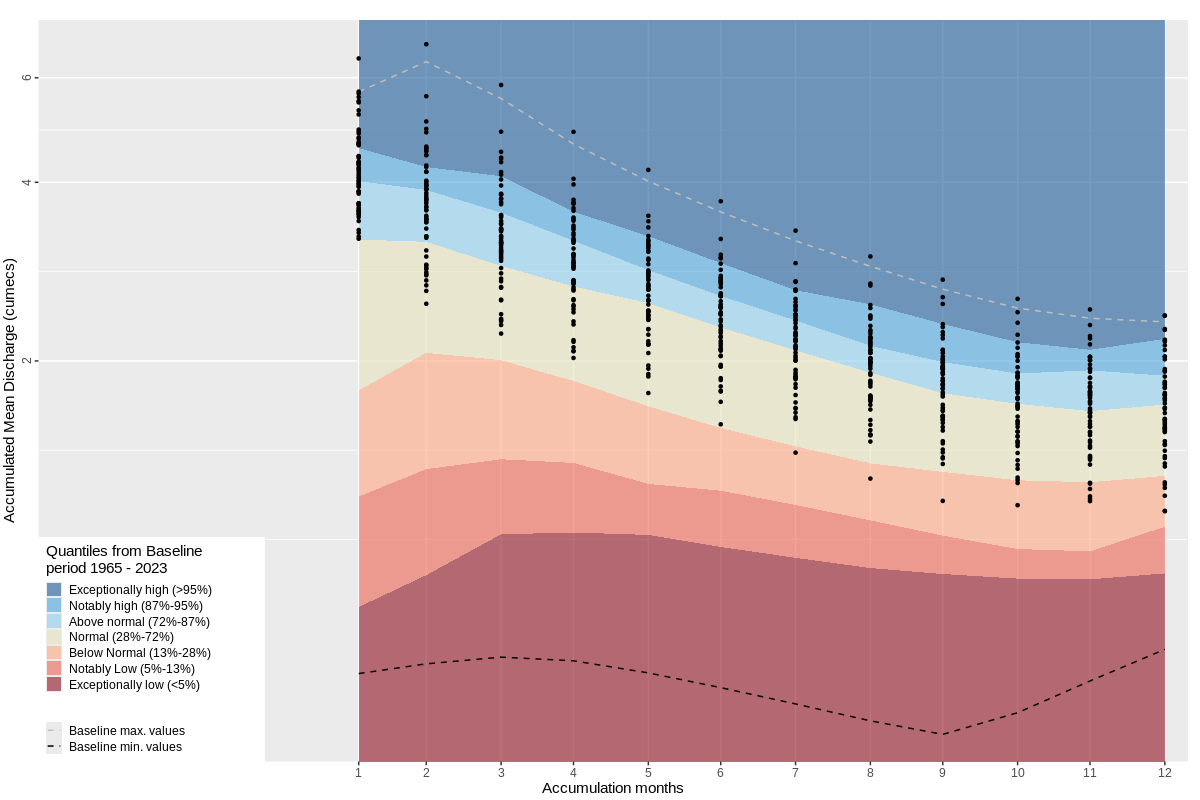

In [ ]:
ESP_plot <-as.data.frame(t(ESP_Aggr))
# the date will be the first day of the next month since the Acc periods
# are defined till the end of the last day of the previous month, eg start
# of the first day of the next month
ESP_plot$DATE <- as.Date(index(ESP) + 1/12)

ESP_plot <- melt(ESP_plot, id='DATE')
colnames(ESP_plot)[2:3] <- c('Member', 'Discharge')
# again dummy for adding the extra dates for same alignment of plots
Dummy <- data.frame(
  DATE=c(min(Plt_data_melt$DATE), max(Plt_data_melt$DATE)),
  Member=NA, Discharge=NA)
ESP_plot <- rbind(Dummy, ESP_plot)
ESP_plot$Acc <- Used_Dates$seq[match(ESP_plot$DATE, Used_Dates$date)]
ESP_plot <- ESP_plot[order(ESP_plot$Acc),]

Q_plots <- as.data.frame(t(Aggr_stats))
# create dummy columns for min and max for shading the areas
Q_plots$`110%` <- max(Q_plots, ESP_plot$Discharge, na.rm = T) *1.1
Q_plots$`-10%` <- min(Q_plots, ESP_plot$Discharge, na.rm = T) *.9
Q_plots <- Q_plots[,c(ncol(Q_plots), 1:(ncol(Q_plots)-1))]
Q_plots <- Q_plots[,ncol(Q_plots):1]
# reorder and move at the end the Q0, Q100, since these values are not
# used for the shaded areas, but only for the dotted lines
Q_plots <- Q_plots[,c(1, 3:8, 10, 2, 9)]
Q_plots$DATE <- as.Date(index(ESP) + 1/12) # same as ESP DATE column
Q_plots$Acc <- match(Q_plots$DATE, Plt_data$DATE)

PLOT2 <- ggplot(data=Q_plots, aes(x=Acc))

for (k in 1:(length(Used_quant)-1)){ # start loop of quantiles

  PLOT2 <- PLOT2 +
    geom_ribbon(aes_q(ymin=as.name(colnames(Q_plots)[k]),
                      ymax=as.name(colnames(Q_plots)[k+1]),
                      fill=paste0('S', k)), alpha=.6)

} # end loop of quantiles

PLOT2 <- PLOT2 +
  geom_line(aes(y=`100%`, col='Baseline max. values'), linetype = "dashed") +
  geom_line(aes(y=`0%`, col='Baseline min. values'), linetype = "dashed") +
  geom_point(data=ESP_plot, aes(x=Acc, y=Discharge), size=.9) +
  labs(x='Accumulation months', y='Accumulated Mean Discharge (cumecs)') +
  scale_y_log10(expand = c(0.0, 0.0), breaks=pretty_breaks(n = 4)) +
  scale_x_continuous(expand = c(0.01, 0.01), breaks=unique(Q_plots$Acc),
                     minor_breaks = NULL, labels = seq(1:length(unique(Q_plots$Acc))),
                     limits=(c(min(ESP_plot$Acc), max(ESP_plot$Acc)))) +
  guides(fill=guide_legend(ncol=1, title=TITLE, order=1),
         color = guide_legend(title.theme =element_blank(), order = 2)) +
  scale_fill_manual(values=rev(COLORS), labels=LABELS) +
  scale_color_manual(values=c('grey', 'black'))+
  theme(legend.position = c(0.0,0.0), legend.justification=c(0, 0),
        legend.key.size = unit(.4, "cm"),
        plot.margin=unit(c(.5,.3,.1,.1),"cm"),
        axis.text.y = element_text(angle=90, hjust=.5),
        legend.box.background = element_rect(fill='white', colour = 'white'))

        print(PLOT2)

This plot (subplot 2) puts the flow forecasts in context to what is normal for this catchment at this time of year. The background colours represent what is exceptionally low > normal > exceptionally high according to the baseline period (1965 to 2023).

Each ensemble members' flow value is then plotted as a dot on this chart so we can see where they sit relative to the historic norm.

Here we can see, if you've run catchment 39020, the one month forecast is quite high. None of the ensemble members sit in the normal, below normal, notably low, or exceptionaly low bands.

Generally, as an ESP forecast lead time lengthens (to 6 to 12 months for example), the forecast will trend back to "normal". The dots will sit in the same distribution as we would expect in a climatology forecast. We can see this more in the next plot.

## Section for creating Subplot 3

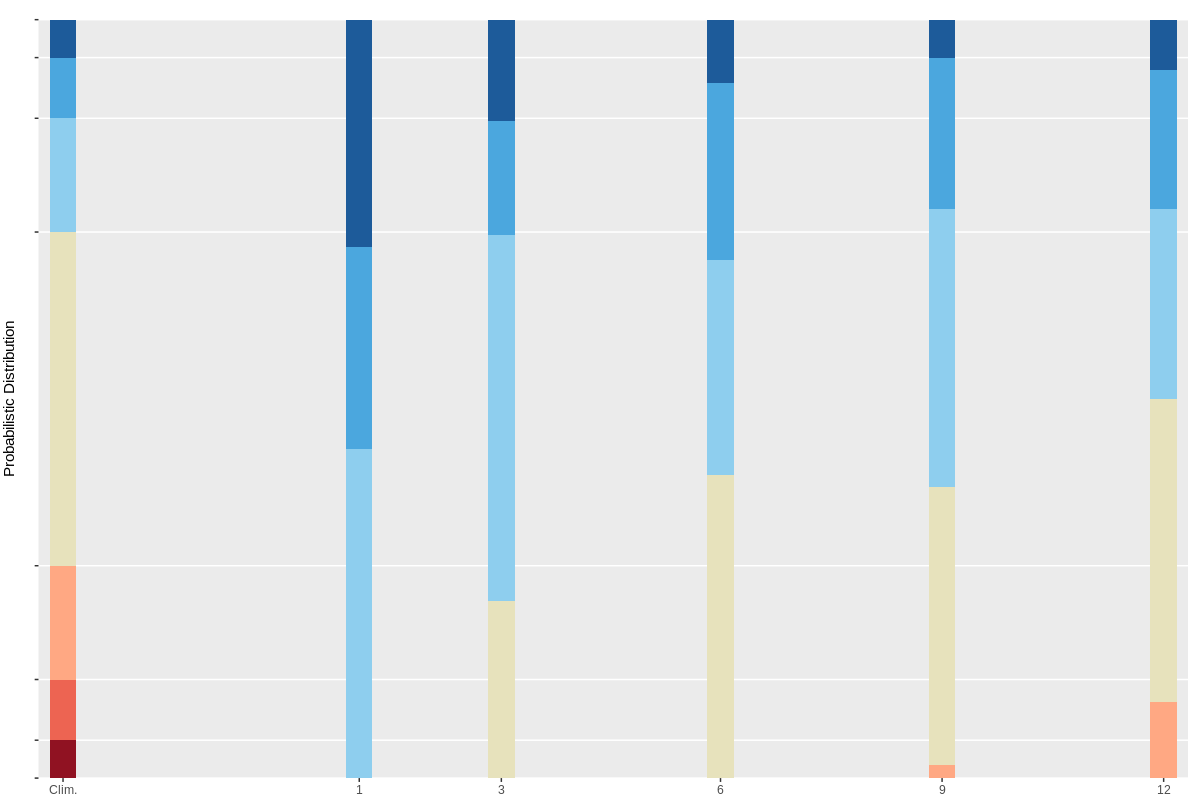

In [ ]:
Ac_0 <- diff(Used_quant)*100
Final_Quant1 <- as.data.frame(Final_Quant)
Final_Quant1 <- cbind(Ac_0=Ac_0, Final_Quant1)
Final_Quant1 <- as.data.frame(t(Final_Quant1))
Final_Quant1$DATE <- c(Plt_data_melt$DATE[1], as.Date(index(ESP) + 1/12))

Final_melted <- melt(Final_Quant1, id='DATE')
colnames(Final_melted)[2:3] <- c('Quantile', 'Percentage')
Final_melted$Acc <- Used_Dates$seq[match(Final_melted$DATE, Used_Dates$date)]
Used_dates <- as.yearmon(Forecast_Date) + (q_m-1)/12
Used_dates <- c(min(Plt_data$DATE), as.Date(index(ESP) -2/12)[1],
                as.Date(Used_dates + 1/12))
Final_melted <- Final_melted[Final_melted$DATE %in% Used_dates,]
Final_melted$Quantile <- factor(Final_melted$Quantile, ordered = T,
                                levels=rev(unique(Final_melted$Quantile)))

PLOT3 <- ggplot(Final_melted, aes(x=Acc, y=Percentage, fill=Quantile)) +
  geom_bar(stat='identity', show.legend = F, width = 11) +
  labs(y='Probabilistic Distribution') +
  scale_y_continuous(expand = c(0.0, 0.0), minor_breaks = F,
                     breaks=Used_quant*100,
                     labels=rep('', length(Used_quant))) +
  scale_x_continuous(expand = c(0.01, 0.01), minor_breaks = NULL,
                     labels = c('Clim.',q_m), breaks = unique(Final_melted$Acc)) +
  scale_fill_manual(values=rev(c(COLORS))) +
  theme(axis.text.y = element_text(angle=90, hjust=.5),
        plot.margin=unit(c(.5,.3,.1,.1),"cm"),
        axis.title.x=element_blank())

print(PLOT3)


This subplot (3) effectively counts up how many dots (ensemble members) sit in each of the categories for each lead time. This more clearly shows whether the forecast is high, low, or about normal.

The bar on the far left shows what we would expect the forecast to look like according to climatology. We would expect most ensemble members to be in the "normal" category, quite a few in the "above normal" and "below normal" categories, a few less in the "notably high" and "notably low" categories and just a couple in the far extremes.

This plot (for 39020) shows a very wet forecast for January, trending back towards normal over the 12 month lead time. It is interesting to note though that even the 12 month accumulated forecast does not match the climatology bar. This is because this is a very slowly responding catchment with a significant groundwater element supplementing the flows. With such a wet January, the forecast suggests that low flows are unlikely, even a year later.

Once you've run through this whole notebook, go back and have a go at running it for 81002 and see how much more quickly the forecast gets back to climatology. You can open up the notebook again in a second tab to look at them side by side.

## Section for creating the Subplot 4 - listing CRPSS under Subplot 3

Warning message:
“The `label.size` argument of `geom_label()` is deprecated as of ggplot2 3.5.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_label()`).”


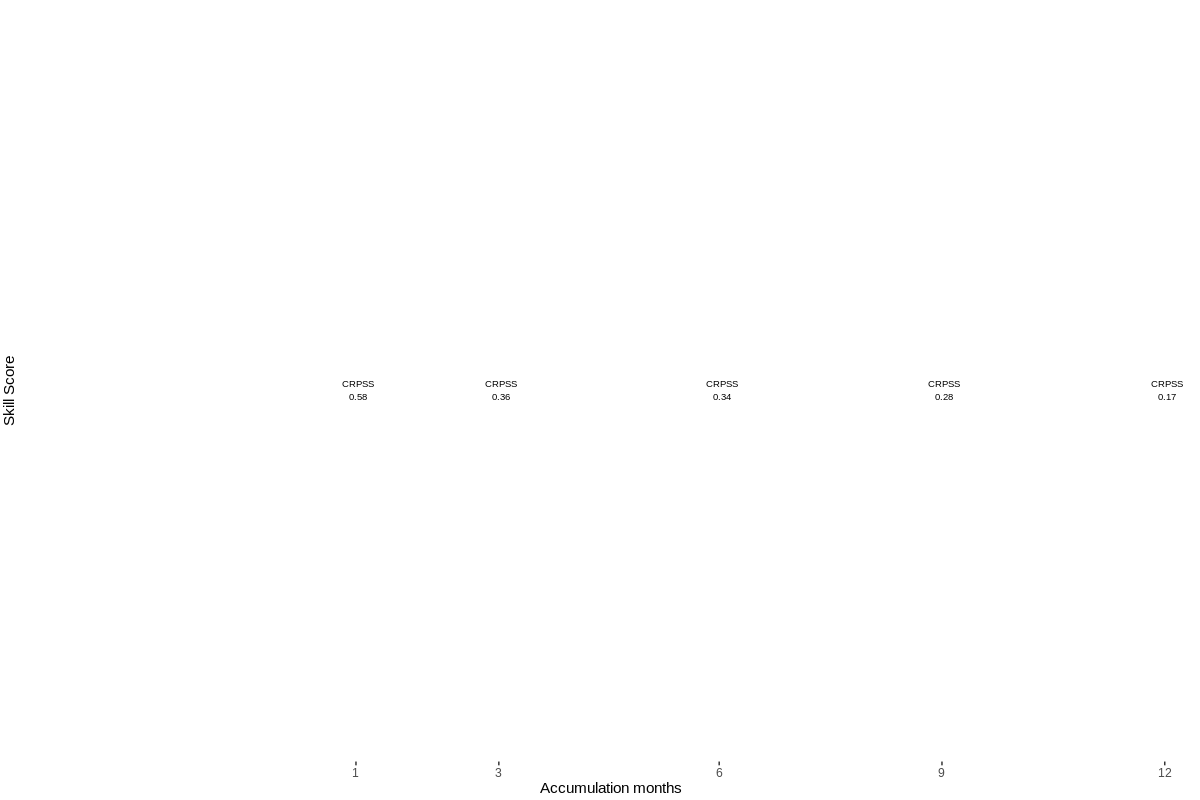

In [ ]:
skill_used <- which(skill$DATE %in% (unique(Final_melted$DATE)-1))
skill_used <- skill[skill_used, ]
skill_used$seq<-unique(Final_melted$Acc)[-1]
skill_used$DATE <- skill_used$DATE + 1 # for plotting on the end of the day
skill_used$seq <- skill_used$seq + 1 # for plotting on the end of the day
skill_used$SKILL <- round(as.numeric(skill_used$SKILL), 2)

# again extra dates for alignment of plots
Dummy <- data.frame(
  DATE=c(min(Plt_data_melt$DATE), max(Plt_data_melt$DATE)), SKILL=NA)
Dummy$seq <- Used_Dates$seq[match(Dummy$DATE, Used_Dates$date)]
skill_used <- rbind(Dummy, skill_used)
skill_used$Percentage <- -5
skill_used$Text <- paste0('CRPSS\n', skill_used$SKILL)
skill_used$Text[is.na(skill_used$SKILL)] <- NA

PLOT4 <- ggplot(skill_used, aes(x=seq, y=0)) +
  geom_label(aes(label=Text), size=2.4, label.size = NA) +
  labs(x='Accumulation months', y='Skill Score') +
  scale_y_continuous(expand = c(0.0, 0.0), limits = c(-0.01, 0.01),
                     breaks=0, labels='') +
  theme(axis.text.y = element_text(angle=90, hjust=.5)) +
  scale_x_continuous(expand = c(0.01, 0.01), minor_breaks = NULL,
                     labels = c(q_m), breaks = unique(Final_melted$Acc)[-1]) +
  scale_fill_manual(values=rev(c(COLORS[-1]))) +
  theme(axis.text.y = element_text(angle=90, hjust=.5),
        plot.margin=unit(c(.5,.3,.1,.1),"cm"),
        axis.ticks.y=element_blank(),
        strip.background = element_blank(),
        panel.background = element_blank())

print(PLOT4)


## Section for creating the Subplot 5 (text at the bottom)

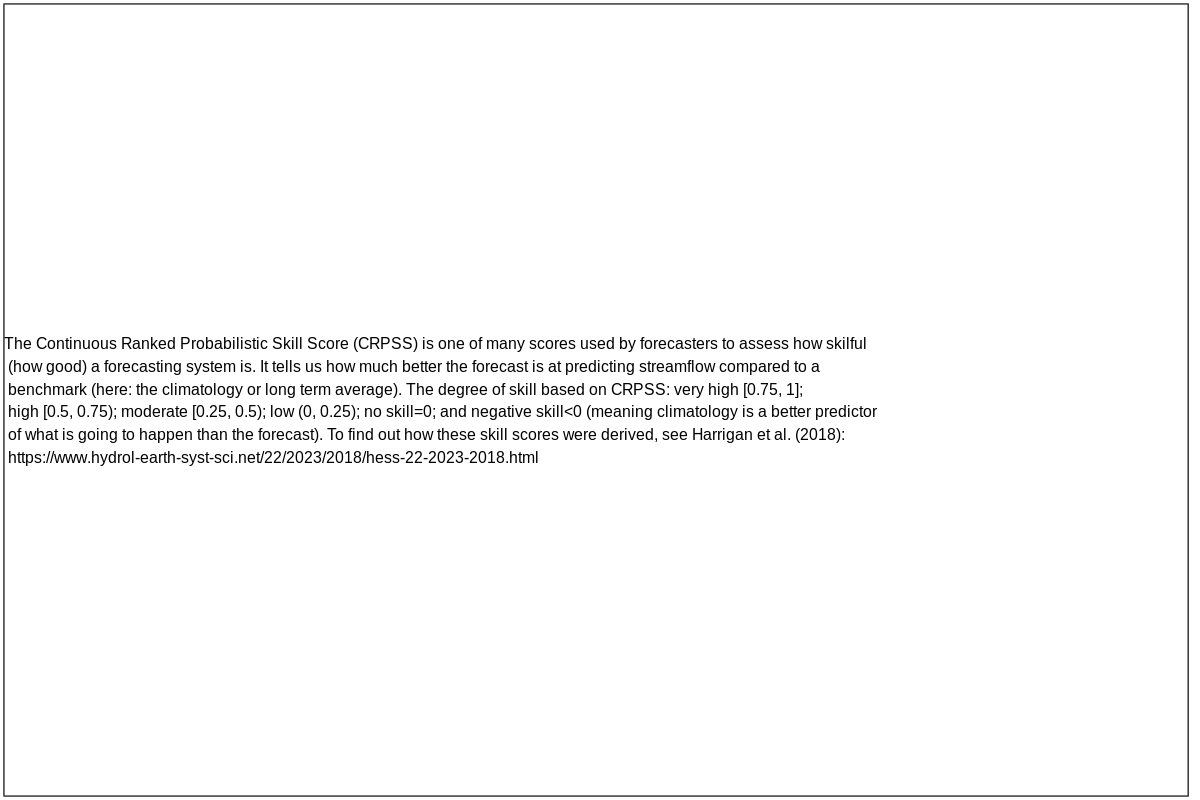

In [ ]:
# text for the final plot with explanation of the CRPSS skill score
text = paste('The Continuous Ranked Probabilistic Skill Score (CRPSS) is one of many scores used by forecasters to assess how skilful\n',
             '(how good) a forecasting system is. It tells us how much better the forecast is at predicting streamflow compared to a\n',
             'benchmark (here: the climatology or long term average). The degree of skill based on CRPSS: very high [0.75, 1];\n',
             'high [0.5, 0.75); moderate [0.25, 0.5); low (0, 0.25); no skill=0; and negative skill<0 (meaning climatology is a better predictor\n',
             'of what is going to happen than the forecast). To find out how these skill scores were derived, see Harrigan et al. (2018):\n',
             'https://www.hydrol-earth-syst-sci.net/22/2023/2018/hess-22-2023-2018.html')

PLOT5 <- ggplot() + annotate("text", x = -Inf, y = 0,
                             size=4, label = text, hjust=0) +
  scale_x_continuous(breaks=NULL, limits = range(skill_used$seq)) +
  scale_y_continuous(breaks=0, labels='') + theme_bw() +
  theme(panel.grid.major=element_blank(),
        panel.grid.minor=element_blank(),
        plot.margin=unit(c(.1,.3,.1,.1),"cm"),
        axis.ticks.y=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
        axis.title.x=element_blank(),
        strip.background = element_blank(),
        panel.background = element_blank())

        print(PLOT5)

## Section for combining all plots in one figure and saving it as png file

In [ ]:
# Title of the plot
if(stn_id == "39020"){
  Main_t <- paste0('12-month ESP forecast from ',
                   format(Forecast_Date, '%B %Y'), '\n',
                   'Catchment: ', CatInfo[1,2], ' at ',
                   CatInfo[1,3], ' (', stn_id, ')')
}
if(stn_id == "81002"){
  Main_t <- paste0('12-month ESP forecast from ',
                   format(Forecast_Date, '%B %Y'), '\n',
                   'Catchment: ', CatInfo[2,2], ' at ',
                   CatInfo[2,3], ' (', stn_id, ')')
}


ggsave(filename = paste0("ESP_Output_", stn_id, ".png"),
       plot = arrangeGrob(PLOT1, PLOT2, PLOT3, PLOT4, PLOT5,
                          heights = c(1.5, 1.2, .8, 0.4, 0.6),
                          top = textGrob(Main_t, gp=gpar(fontsize=18,font=8))),
       width = 23, height = 30, units = 'cm')


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_step()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_label()`).”


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_step()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_label()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_step()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_label()`).”


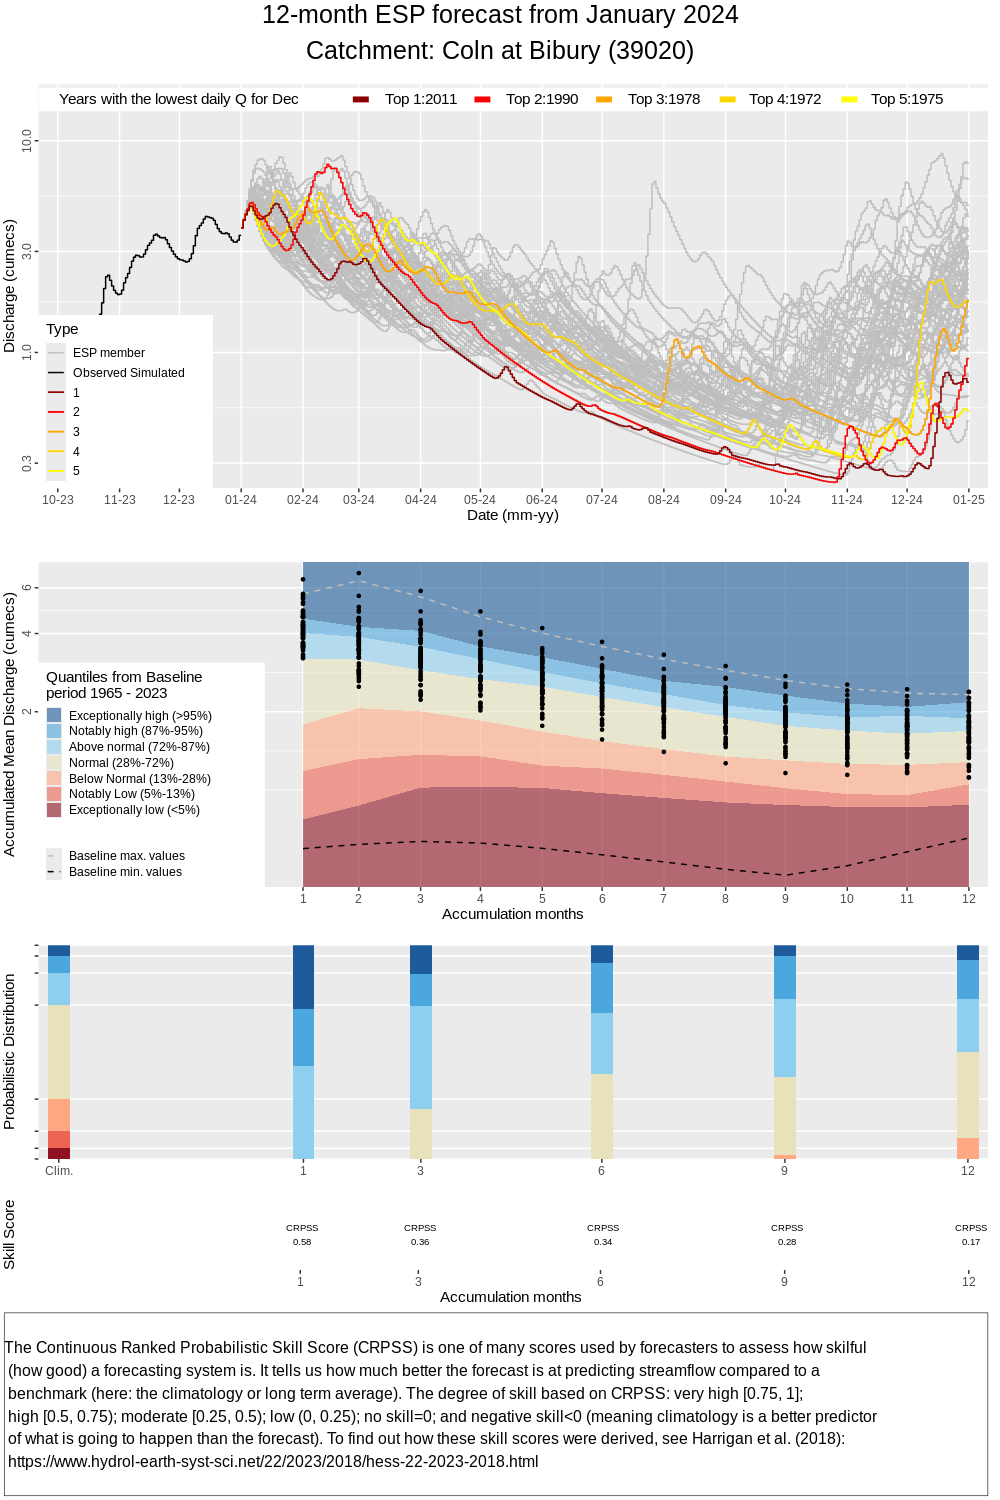

In [ ]:
#set the dimensions of the total plot (for colab workbook)
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res = 100)
# Title of the plot
if(stn_id == "39020"){
  Main_t <- paste0('12-month ESP forecast from ',
                   format(Forecast_Date, '%B %Y'), '\n',
                   'Catchment: ', CatInfo[1,2], ' at ',
                   CatInfo[1,3], ' (', stn_id, ')')
}
if(stn_id == "81002"){
  Main_t <- paste0('12-month ESP forecast from ',
                   format(Forecast_Date, '%B %Y'), '\n',
                   'Catchment: ', CatInfo[2,2], ' at ',
                   CatInfo[2,3], ' (', stn_id, ')')
}

# ---- PRINT FIGURE IN NOTEBOOK (Colab) ----
grid::grid.newpage()
grid::grid.draw(
  arrangeGrob(
    PLOT1, PLOT2, PLOT3, PLOT4, PLOT5,
    heights = c(1.5, 1.2, .8, 0.4, 0.6),
    top = textGrob(Main_t, gp = gpar(fontsize = 18, font = 8))
  )
)

# ---- SAVE FIGURE TO FILE ----
ggsave(
  filename = paste0("ESP_Output_", stn_id, ".png"),
  plot = arrangeGrob(
    PLOT1, PLOT2, PLOT3, PLOT4, PLOT5,
    heights = c(1.5, 1.2, .8, 0.4, 0.6),
    top = textGrob(Main_t, gp = gpar(fontsize = 18, font = 8))
  ),
  width = 23, height = 30, units = "cm"
)


Here it is! This is a combination of the above plots, aligned neatly into one sheet.

**Let us know what you think of it!**

*Would this be useful to you for decision making?*

*How else would you like to see forecasts presented?*